In [1]:
# Use specific rate matrix to solve master equation with ODE solver and then create plot with results
# Used in comparison of small box algorithm with the smaller cases.
# Kinectic code has since changed so some functions might not work in current format.

In [2]:
import math
import numpy as np
import nupack4
from nupack4 import State, Model
import scipy.stats


In [3]:
# Function to find structure matrix
def structure_matrix(secondary_structure):
    lengd = len(secondary_structure)
    leftB = []
    rightB = []
    Smatrix = np.zeros([lengd,lengd])
    
    for i in range(lengd):
        if secondary_structure[i] == '(':
            leftB.append(i)
        elif secondary_structure[i] == ')':
            rightB.append(i)
        
    for x,y in list(enumerate(leftB)):
        Smatrix[y,rightB[len(rightB)-1-x]] = 1
        Smatrix[rightB[len(rightB)-1-x], y] = 1
    Smatrix += np.diag(1-Smatrix.sum(0))
    return Smatrix

In [4]:
# Function to find pair probability matrix
def pair_probability(small_pi, w, i):
    '''Takes in secondary structure and stationary distribution and gives out the pair probability matrix'''
    P = small_pi[i]*structure_matrix(w)
    return P
    

In [5]:
def change_to_macro(PP_Matrix_Collector, macro_States, all_states, vec, small_pi):
    '''Takes in pair probability matrices, macro states, all the secondary structure, stationary distribution and
    vector with the population of every secondary structure at each time'''
    
    P_2 = []
    
    for i in range(len(macro_States)):
        for k in range(len(all_states)):
            if macro_States[i] == all_states[k].dp:
                P_2.append(pair_probability(small_pi, macro_States[i], k))
    
    Collector = []
    for i in range(len(PP_Matrix_Collector)):                         # Every time step
        vec_counter = np.zeros(len(macro_States))
        for j in range(len(PP_Matrix_Collector[i])):                  # Every iteration, matrix
            P_1 = PP_Matrix_Collector[i][j]
            diff_vec = np.zeros(len(macro_States))
            for k in range(len(P_2)):
                diff_vec[k] = np.linalg.norm((P_1 - P_2[k]))
            vec_counter[np.argmin(diff_vec)] += vec[i][j]
        Collector.append(vec_counter)   
    
    return Collector


In [ ]:
# Use rate matrix from small_box to solve coarse grained master equation

import matplotlib.pyplot as plt
import seaborn as sns

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
sns.set(style='whitegrid', palette=colors, rc={'axes.labelsize': 16})

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}


def nytt(vec,t):
    dvecDt = vec@R
    return dvecDt

y0 = np.array([0,0,0,0,1,0,0,0,0,0,0,0])
t = np.linspace(0,50e-4,num = 1000)
R = np.asarray([[0,0,8.9306e+01,0,0,0,0,0,0,0,0,0],[0,0,0,1.0789e+00,0,0,0,0,0,0,0,0],[3.0684e+01,0,0,0,0,0,0,0,0,0,0,0],[0,1.0734e-10,0,0,8.9939e+03,9.9933e+02,0,0,0,0,0,0],[0,0,0,3.4844e-02,0,0,5.0631e+09,5.2829e+09,6.5190e+09,5.5438e+09,0,6.0387e+09],[0,0,0,1.3433e-02,4.9807e+00,0,1.6602e+00,1.6602e+00,1.6602e+00,1.6602e+00,0,0],[0,0,0,0,8.9879e+03,8.4943e-07,0,0,0,0,9.9866e+02,0],[0,0,0,0,8.9932e+03,8.1457e-07,0,0,0,0,9.9924e+02,0],[0,0,0,0,9.9927e+03,7.3348e-07,0,0,0,0,0,0],[0,0,0,0,8.9948e+03,7.7638e-07,0,0,0,0,9.9943e+02,0],[0,0,0,0,0,0,8.4792e+02,0,0,0,0,1.0992e+00],[0,0,0,0,9.9910e+03,0,0,0,0,0,1.2066e+00,0]])
R -= np.diag(R.sum(1))

print(np.linalg.eigvals(R))

p_test = np.real(np.linalg.eig(R)[1][:, np.argmin(np.abs(np.real(np.linalg.eigvals(R))))])
p_test = np.real(np.linalg.eig(R)[1][:, 1])


p_test /= p_test.sum()
print('p', p_test)

vec = scipy.integrate.odeint(nytt ,y0 ,t)

# Smellir upp grunn
fig, ax = plt.subplots(1, 1)
# Setur merkingar a asa
ax.set_xlabel(r'$Time \ ( s )$')
ax.set_ylabel(r'$Dilution \ (nM)$');

Num_Macro = vec

dis = {}
for i in range(len(Num_Macro[0])):
    dis[i] = []
        
for j in range(len(Num_Macro)):    
    for i in range(len(Num_Macro[0])):
        dis[i].append(Num_Macro[j][i])

dis
for i in range(len(dis)):
    _ = ax.plot(t, dis[i]/sum(Num_Macro[i]))



#_ = ax.plot(t, np.transpose(vec[:,0])/(np.transpose(vec[:,0])+np.transpose(vec[:,1])+np.transpose(vec[:,2])+np.transpose(vec[:,3])))
#_ = ax.plot(t, np.transpose(vec[:,1])/(np.transpose(vec[:,0])+np.transpose(vec[:,1])+np.transpose(vec[:,2])+np.transpose(vec[:,3])))
#_ = ax.plot(t, np.transpose(vec[:,2])/(np.transpose(vec[:,0])+np.transpose(vec[:,1])+np.transpose(vec[:,2])+np.transpose(vec[:,3])))
#_ = ax.plot(t, np.transpose(vec[:,3])/(np.transpose(vec[:,0])+np.transpose(vec[:,1])+np.transpose(vec[:,2])+np.transpose(vec[:,3])))

ax.legend(('Macrostate 1', 'Macrostate 2', 'Macrostate 3','Macrostate 4'), loc='upper right');
#ax.set_xscale('log')
#plt.savefig('DiffEqSolved_SmallBoxRateMatrix_ThridjaDaemid.png', bbox_inches='tight')
print(vec)

779
should be 0 4.58466868887e-10
should be 0 3.93433310819e-06
integrating 10000
0 0.0 1.0 1.0 3557.79935475
2000 1.1418143476121031e-06 1.0 0.628885361715 154.439499764
4000 2.2872200523279443e-06 1.0 0.600598231838 22.9452809687
6000 3.4271605660828223e-06 1.0 0.59401063008 16.1589629993
8000 4.572707341112936e-06 1.0 0.589466394448 15.5169121901
10000 5.716729180479424e-06 1.0 0.585270092938 15.0006905682
12000 6.8582553537391e-06 1.0 0.581238357016 14.5796761238
14000 8.000800080008e-06 1.0 0.577319227021 14.225078453
16000 9.14261436580347e-06 1.0 0.573499051891 13.919468228
18000 1.0288020062429601e-05 1.0 0.569750118505 13.6500579684
20000 1.1427960622129364e-05 1.0 0.566091864162 13.4089998973
22000 1.2573507391394834e-05 1.0 0.562481099441 13.1895409923
24000 1.3717529241353353e-05 1.0 0.558934650982 12.9871311823
26000 1.4859055417960618e-05 1.0 0.555450426973 12.7997852187
28000 1.6001600160016002e-05 1.0 0.552013680829 12.6241561228
30000 1.714341443814386e-05 1.0 0.548626

266000 0.00015201520152014592 1.0 0.295095753588 5.39883061863
268000 0.00015315701579216712 1.0 0.293713364843 5.36545852214
270000 0.0001543024214824246 1.0 0.292335496625 5.33291741655
272000 0.00015544236205360391 1.0 0.290972953071 5.2993951676
274000 0.00015658790881805014 1.0 0.289612434009 5.26715891881
276000 0.00015773193067109036 1.0 0.288488669263 5.23429464825
278000 0.0001588734568485822 1.0 0.290366279757 5.20219519585
280000 0.00016001600160015257 1.0 0.292240403397 5.17019071668
282000 0.00016115781587218135 1.0 0.294108179898 5.13856005369
284000 0.00016230322156244518 1.0 0.295976670368 5.10775092604
286000 0.00016344316213361715 1.0 0.297831124284 5.07593779429
288000 0.00016458870889806787 1.0 0.299689562248 5.0454048259
290000 0.00016573273075110826 1.0 0.301540398677 5.01422702189
292000 0.0001668742569285997 1.0 0.303382100792 4.98379629636
294000 0.0001680168016801592 1.0 0.305220359021 4.95344800561
296000 0.00016915861595219583 1.0 0.307052368117 4.9234585410

532000 0.00030403040304026403 1.0 0.490815365602 3.06274971111
534000 0.000305172217312441 1.0 0.492120289499 3.05385400928
536000 0.000306317623002821 1.0 0.493425505179 3.04563449255
538000 0.0003074575635738536 1.0 0.494720711836 3.03608680738
540000 0.0003086031103383916 1.0 0.496018498074 3.02771721714
542000 0.0003097471321914277 1.0 0.497310774831 3.01845911991
544000 0.00031088865836891304 1.0 0.498596475415 3.00969336393
546000 0.0003120312031202696 1.0 0.499879575145 3.00082022729
548000 0.00031317301739245464 1.0 0.50115811829 2.9920880223
550000 0.00031431842308284085 1.0 0.502436940167 2.98403226697
552000 0.0003154583636538659 1.0 0.503705948375 2.9746472413
554000 0.00031660391041840873 1.0 0.504977476969 2.96644089694
556000 0.0003177479322714443 1.0 0.506243600599 2.9573454749
558000 0.0003188894584489294 1.0 0.50750327428 2.94874186649
560000 0.00032003200320027516 1.0 0.508760392956 2.94003060031
562000 0.00032117381747246815 1.0 0.510013040574 2.93145995439
564000 0

796000 0.0004549030598091883 1.0 0.633901017586 2.07309120219
798000 0.00045604560456036973 1.0 0.634784852115 2.06680657718
800000 0.0004571874188326852 1.0 0.635665487655 2.06065670043
802000 0.0004583328245231705 1.0 0.636546255184 2.05518607728
804000 0.0004594727650940751 1.0 0.637420204597 2.04836789625
806000 0.00046061831185869467 1.0 0.638295830906 2.04273614242
808000 0.00046176233371172264 1.0 0.63916767679 2.0362054503
810000 0.0004629038598892023 1.0 0.64003502369 2.03015674853
812000 0.00046404640464037527 1.0 0.640900554275 2.0239952192
814000 0.000465188218912697 1.0 0.641762950005 2.01796809333
816000 0.0004663336246031872 1.0 0.642625472884 2.01262030483
818000 0.000467473565174086 1.0 0.643481316807 2.00592405753
820000 0.0004686191119387093 1.0 0.644338800818 2.0004145509
822000 0.00046976313379173674 1.0 0.645192580684 1.99400560703
824000 0.0004709046599692163 1.0 0.64604195277 1.98807813286
826000 0.00047204720472038085 1.0 0.646889544178 1.9820375569
828000 0.00

1062000 0.0006069182613294356 1.0 0.731006273865 1.38975551542
1064000 0.0006080608060804754 1.0 0.731598776259 1.38546391214
1066000 0.0006092026203528975 1.0 0.732189114917 1.38130110016
1068000 0.0006103480260434622 1.0 0.732779522937 1.37781852892
1070000 0.0006114879666142687 1.0 0.733365341708 1.3729735927
1072000 0.0006126335133789473 1.0 0.733952265765 1.36931974751
1074000 0.0006137775352319709 1.0 0.734536637244 1.36475867034
1076000 0.0006149190614094477 1.0 0.735117974839 1.36067075749
1078000 0.000616061606160481 1.0 0.735698076862 1.35646536908
1080000 0.0006172034204329074 1.0 0.736276059805 1.35238849921
1082000 0.0006183488261234756 1.0 0.736854110035 1.34899189775
1084000 0.0006194887666942783 1.0 0.737427666458 1.34423228226
1086000 0.0006206343134589595 1.0 0.738002304418 1.34066394275
1088000 0.0006217783353119827 1.0 0.738574442626 1.33618800393
1090000 0.0006229198614894594 1.0 0.739143609863 1.33218483163
1092000 0.0006240624062404866 1.0 0.7397115668 1.32806397

1324000 0.0007566479148191464 1.0 0.795205151886 0.934978463278
1326000 0.0007577919366721673 1.0 0.795604098757 0.931716576608
1328000 0.0007589334628496419 1.0 0.796000969051 0.928921652338
1330000 0.000760076007600581 1.0 0.796396990521 0.926006014577
1332000 0.0007612178218730782 1.0 0.796791560083 0.9232147074
1334000 0.0007623632275636995 1.0 0.797186170337 0.921103973695
1336000 0.0007635031681344367 1.0 0.797577707698 0.917620462537
1338000 0.0007646487148991565 1.0 0.797969978225 0.915330869262
1340000 0.0007657927367521774 1.0 0.798360537224 0.912128158942
1342000 0.0007669342629296519 1.0 0.798749063116 0.909392085595
1344000 0.0007680768076805866 1.0 0.799136757843 0.906535168029
1346000 0.0007692186219530869 1.0 0.799523031002 0.903802387207
1348000 0.0007703640276437103 1.0 0.799909343814 0.901750187665
1350000 0.0007715039682144448 1.0 0.800292648162 0.89832476519
1352000 0.0007726495149791663 1.0 0.800676670078 0.896093375932
1354000 0.000773793536832187 1.0 0.801059016

1582000 0.0009040904090406812 1.0 0.837808498553 0.631411688991
1584000 0.0009052322233132268 1.0 0.83807754255 0.629508594435
1586000 0.0009063776290038849 1.0 0.838346612634 0.628286079875
1588000 0.0009075175695745771 1.0 0.838613585788 0.625684059547
1590000 0.0009086631163393235 1.0 0.838881057229 0.62427766825
1592000 0.0009098071381923432 1.0 0.839147360041 0.62195484495
1594000 0.0009109486643698164 1.0 0.839412274982 0.620093251219
1596000 0.0009120912091206868 1.0 0.839676621617 0.618109118348
1598000 0.0009132330233932348 1.0 0.839939997401 0.616246250502
1600000 0.0009143784290838947 1.0 0.840203398663 0.615063961177
1602000 0.0009155183696545845 1.0 0.840464747116 0.612501861294
1604000 0.0009166639164193322 1.0 0.8407265833 0.611135466045
1606000 0.0009178079382723522 1.0 0.840987275418 0.608852518303
1608000 0.0009189494644498249 1.0 0.841246608851 0.607030493762
1610000 0.0009200920092006922 1.0 0.841505385895 0.605085882659
1612000 0.0009212338234732424 1.0 0.841763212

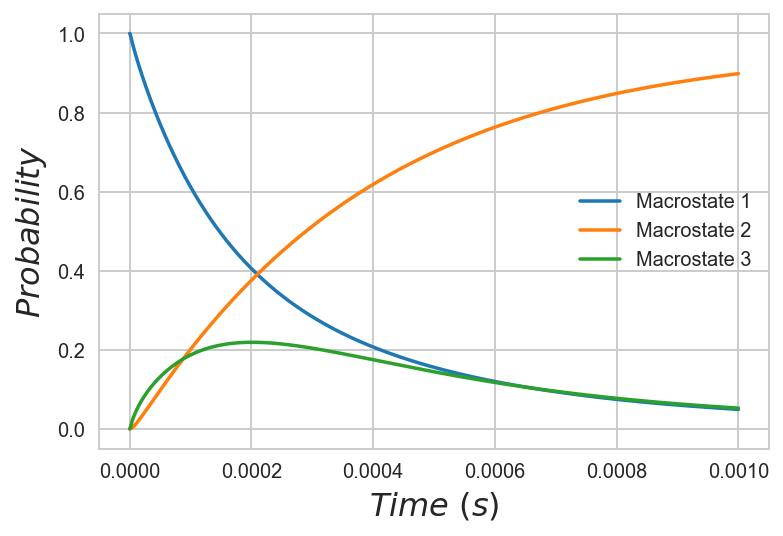

In [29]:
# Use Rate matrix (R) from enumerated solution to solve coarse grained master equation

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import ode

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
sns.set(style='whitegrid', palette=colors, rc={'axes.labelsize': 16})

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Define change in every time step for ODE solver
def nytt(t, vec, i=[0]):
    dvecDt = vec @ R
    if i[0] % 2000 == 0: print(i[0], t, vec.sum(), vec.max(), np.abs(dvecDt).mean())
    i[0] += 1
    return dvecDt

# Define rate matrix (R), all possible secondary structures and the initial state
mod = Model(dangles='none', gt=True)
w = State('GCGUCGCGUCGCUAUGC',kind='slow',model=mod)
all_states,pi,R = w.rate_matrix(sparse=True)
print(len(all_states))
#R /= 1e6
state = State('GCGUCGCGUCGCUAUGC', kind = 'slow', model = mod)

print('should be 0', np.abs(pi @ R).sum())
print('should be 0', np.abs(R.sum(1)).sum())


#R = State('GCGUCGCGUCGCUACGC + ', kind = 'slow').rate_matrix()
#all_states = sorted(State('GCGUCGCGUCGCUACGC', kind = 'slow').enumerated())
state = State('GCGUCGCGUCGCUAUGC','.....((((....))))', kind = 'slow', model = mod)

y0 = np.zeros(len(all_states))     #Initial dilution (i.e. everything zero except the initial state)
for x,y in enumerate(all_states):
    if y.dp == state.dp:
        y0[x] += 1
        
# Define the time vector
t = np.linspace(0., 0.001, num=10000)
# Solve the differential equation
print('integrating', len(t))
def odeint2(f, x0, times):
    ret = np.zeros(times.shape + x0.shape)
    ret[0] = x0 
    
    r = ode(f).set_integrator('dopri5')
    r.set_initial_value(x0, times[0])
    for i in range(1, len(times)):
        r.integrate(r.t + times[i] - times[i-1])
        ret[i] = r.y
        # ret[i] = ret[i-1] + (t[i] - t[i-1]) * f(ret[i-1], t)
    return ret

vec = odeint2(nytt ,y0 ,t)




print('done')
# Define sequence, macro states from small box and stationary distribution 
seq = 'GCGUCGCGUCGCUAUGC'
#macro_States = ['..(((...)))((((...)))).','...((...))(((((...)))))','..........(((((...)))))', '(((((((.((...)).)))))))','.....((((((......))))))']
macro_States = ['.....((((....))))','((((.((...)).))))','(((......))).....']
# Find pair probability matrix for every secondary structure
def structure_matrix_of_state(state):
    ret = np.zeros([len(state.pairs)] * 2)
    for i, j in enumerate(state.pairs): 
        ret[i, j] = 1
    return ret
    
structure_matrices = [structure_matrix_of_state(w) for w in all_states]
#PP_Matrix_Every_State = []
#for i in range(len(all_states)):
#    PP_Matrix_Every_State.append(pair_probability(small_pi, all_states[i].dp, i))

macro_ws = [State(seq, dp, model=mod, kind='slow') for dp in macro_States]

def macro_map(all_states, macro_ws, pi):
    """
    Returns map of which macro each states is in, PP of the macro, probability of the macro
    """
    ret = np.zeros([len(all_states)], dtype=np.int32)
    pps = np.zeros([len(macro_ws), len(macro_ws[0].pairs), len(macro_ws[0].pairs)])
    pis = np.zeros([len(macro_ws)])
    for i, w in enumerate(all_states):
        distances = [np.sum(m.pairs.array() != w.pairs.array()) for m in macro_ws]
        j = distances.index(min(distances))
        ret[i] = j
        pps[j] += w.boltz * structure_matrix_of_state(w)
        pis[j] += w.boltz
    for j in range(len(macro_ws)):
        pps[j] /= pis[j]
    pis /= pis.sum()
    return ret, pps, pis

macro_map, PPs, macro_pis = macro_map(all_states, macro_ws, pi)
print(vec.shape)

def transform_vec(vec, macro_map, n):   
    ret = np.zeros([len(vec), n])
    for t in range(len(vec)):
        for j in range(len(vec[t])):
            ret[t, macro_map[j]] += vec[t, j]
    return ret
    
#PP_Matrix_Collector = []
#for k in t:
#    PP_Matrix_Collector.append(PP_Matrix_Every_State)

# Find number macro states
#Num_Macro = change_to_macro(PP_Matrix_Collector, macro_States, all_states, vec, pi)

macro_vec = transform_vec(vec, macro_map, len(macro_ws))

# Rest of code is for plotting
fig, ax = plt.subplots(1, 1)
ax.set_xlabel(r'$Time \ ( s )$')
ax.set_ylabel(r'$Probability$');

for m in range(len(macro_ws)):
    _ = ax.plot(t, macro_vec[:, m])

#dis = {}
#for i in range(len(Num_Macro[0])):
#    dis[i] = []
        
#for j in range(len(Num_Macro)):    
#    for i in range(len(Num_Macro[0])):
#        dis[i].append(Num_Macro[j][i])


#for i in range(len(dis)):
#    _ = ax.plot(t, dis[i]/sum(Num_Macro[i]))
    
ax.legend(tuple('Macrostate %d' % i for i in range(1,len(macro_ws)+1)), loc='center right');
plt.savefig('DiffEqSolved_EnumeratedRateMatrix_WolfeCase.png', bbox_inches='tight')
#ax.set_xscale('log')


In [ ]:
######################################################################################################################
                                    
                                 # The rest of the notebook is practice and tests

######################################################################################################################

In [ ]:
t = 0
for k in range(5,len(vigur)):
    t+=1

In [ ]:
w = State('AAAATTTT',kind='slow', model=Model(dangles='none'))

In [ ]:
w.run(timer(time=0.1, steps=-1))

In [ ]:
time = w.run(steps=3)

In [ ]:
states, pi, R = w.rate_matrix()

In [ ]:
from nupack4 import time_integrator, scaled_integrator, Model, Engine

In [ ]:
new_w, stop, times = w.run(walltime=2., observers=[time_integrator()])

In [ ]:
list(times.values())

In [ ]:
new_w, stop, times = w.run(walltime=2., observers=[scaled_integrator(1.0)])                                                            

In [ ]:
list(times.values())
# integral of lambda * exp (lambda t) * delta(state i)

In [ ]:
Model(dangles='none'),Model(dangles='min'),Model(dangles='all')

In [ ]:
mod = Model(dangles='none', T=298)
mod.molarity = 1e-5


In [ ]:
dir(mod)

In [ ]:
State('AA').pairs.array()

In [ ]:
print(macro_pis)

In [27]:
range(1,5)

range(1, 5)

In [28]:
for i in range(1,5):
    print(i)

1
2
3
4
